In [140]:
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.exceptions import DataConversionWarning
from pandas import set_option

In [204]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
import xgboost
import torch
import torch.nn as nn
import torch.optim as optim
import copy,math
import scipy
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [162]:
def missing_zero_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([ mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0: 'Missing Values', 1 : '% of Total Values'})
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table.sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
        "There are " + str(mz_table.shape[0]) +
          " columns that have missing values.")
    return mz_table

def RemoveOutlier(df, features = [], qtl_min = 0.01, qtl_max = 0.99):
    df = df.copy(deep = True)
    info_CAP = dict()
    for nameFeature in features:
        q_max = df[nameFeature].quantile(0.99)
        q_min = df[nameFeature].quantile(0.01)
        info_CAP[nameFeature] = (q_min, q_max)
        df.loc[:, nameFeature] = df[nameFeature].apply(lambda x: q_min if x < q_min else q_max if x > q_max else x)
    return df, info_CAP

def find_optimal_cutoff(target, predict):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = metrics.roc_curve(target, predict)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({"tpr" : pd.Series(tpr, index=i), "fpr" : pd.Series(fpr, index=i), 'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return roc_t.to_dict('records')[0]

def split_n(vmin, vmax, nbin):
    wth = (vmax - vmin ) * 1.0 / nbin
    res = [vmin + wth * i for i in range(nbin)] + [vmax]
    return res

def plot_KL_significance(df_data, features, col_target, thresh_n = 30, eps = 0.1, bins = 30):

    # Define your custom boundaries
    boundaries = [i*1.0/100 for i in range(-100, 100 + 20, 20)]  # Customize these as needed
    cmap = plt.get_cmap('seismic', len(boundaries) - 1)
    
    # DataFrame copy
    df_data = df_data.copy()
    
    # target column 
    # col_target = "SeriousDlqin2yrs"

    # K-L result for features 
    info_KL_feature = dict()

    # K-L result for feature segments
    info_KL_feature_seg = dict()

    # K-L result for feature split 
    info_split_feature = dict()

    # discrete and continous features
    ls_feature_discrete = []
    ls_feature_continuous = []

    # iterate all features
    for feature in features:
        
        # check unique values of the feature
        n_unique = df_data[feature].nunique()

        # initialize
        info_KL_feature_seg[feature] = dict()

        # if discrete feature
        if n_unique < thresh_n:
            ls_feature_discrete.append(feature)

            # data 
            data_grp_feature = df_data.groupby(feature).agg({'id': lambda x: len(x), col_target: lambda x: x.sum() })
            data_grp_feature.loc[:, "id_eps"] = data_grp_feature.loc[:, "id"] + eps
            data_grp_feature.loc[:, f"{col_target}_eps"] = data_grp_feature.loc[:, col_target] + eps
            data_grp_feature.loc[:, "pct_id"] = data_grp_feature["id_eps"] * 1.0 / data_grp_feature["id_eps"].sum()
            data_grp_feature.loc[:, f"pct_{col_target}"] = data_grp_feature[f"{col_target}_eps"] * 1.0 / data_grp_feature[f"{col_target}_eps"].sum()
        
            # get the K-L distance for different values
            for fv, row in data_grp_feature.iterrows():
                info_KL_feature_seg[feature][fv] = (row["id"], scipy.special.rel_entr(row[f"pct_{col_target}"], row["pct_id"]))
            info_KL_feature[feature] = np.sum(scipy.special.rel_entr(data_grp_feature[f"pct_{col_target}"].tolist(), data_grp_feature["pct_id"].tolist()))

        else:
            ls_feature_continuous.append(feature)

            # get total count
            sum_ttl = df_data[feature].count()
            sum_tgt = df_data[col_target].sum()

            # all quantile values 
            ls_value_quantile = split_n(vmin = df_data[feature].min(), vmax = df_data[feature].max(), nbin = bins )
            #ls_quantitle = np.array(range(0, 110, 10))/100.0
            #ls_value_quantile = sorted(set(df_data[feature].quantile(ls_quantitle).tolist()))

            # get all segments info
            info_split_feature[feature] = ls_value_quantile

            # iterate all values and get the distribution of the feature vs target
            len_quantile = len(ls_value_quantile)
            ls_feature_count = []
            ls_target_sum = []
            for f in range(1, len_quantile):
                l_max = ls_value_quantile[f]
                l_min = ls_value_quantile[f-1]
                if f == len_quantile-1:
                    df_data_part = df_data[(df_data[feature] >= l_min) & (df_data[feature] <= l_max)]
                else:
                    df_data_part = df_data[(df_data[feature] >= l_min) & (df_data[feature] < l_max)]

                # get the distribution of the features 
                n_value = df_data_part[feature].count() + eps
                n_target = df_data_part[col_target].sum() + eps

                # get the K-L distance 
                info_KL_feature_seg[feature][l_min] = scipy.special.rel_entr(n_target * 1.0 / sum_tgt, n_value * 1.0 / sum_ttl )
                #info_KL_feature_seg[(feature,l_min, l_max )] = np.sum(scipy.special.rel_entr(n_target * 1.0 / sum_tgt, n_value * 1.0 / sum_ttl ))

                # add to list 
                ls_feature_count.append(n_value)
                ls_target_sum.append(n_target)

            # change to array 
            arr_feature_count = np.array(ls_feature_count)
            arr_target_sum = np.array(ls_target_sum)
            arr_feature_count = arr_feature_count * 1.0 / sum_ttl
            arr_target_sum = arr_target_sum * 1.0 / sum_tgt
            info_KL_feature[feature] = np.sum(scipy.special.rel_entr(arr_target_sum, arr_feature_count ))

        #print(feature)

    # get the color list for risk importance plot
    ls_color = sns.color_palette(palette='seismic', n_colors=100).as_hex()

    # iterate all features 
    for feature in ls_feature_continuous:
        
        # get KL info
        info_KL_part = dict(sorted(info_KL_feature_seg[feature].items(), key= lambda x:x[0], reverse= False))
        
        # get color pallate 
        ls_pallete = []
        for k,v in info_KL_part.items():
            s_color = int((v + 1.0) * 100.0 / 2.0)
            ls_pallete.append(ls_color[s_color])

        # create plot
        _, _ = plt.subplots(figsize=(12, 6))
        ax = sns.histplot(data=df_data, x = feature, bins = info_split_feature[feature])

        # Create a colorbar with specified boundaries
        norm = plt.Normalize(min(boundaries), max(boundaries))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=boundaries, boundaries=boundaries, ax=ax)
        cbar.set_label('Risk ( Low -> High)')
        
        # change color
        for p, color in enumerate(ls_pallete):
            ax.patches[p].set_facecolor(ls_pallete[p])
        plt.title(feature)
        plt.show()

    # iterate all features 
    for feature in ls_feature_discrete:
        
        ls_count = [v[0] for k,v in info_KL_feature_seg[feature].items()]
        ls_KL    = [v[1] for k,v in info_KL_feature_seg[feature].items()]
        # get color pallate 
        ls_pallete = []
        for v in ls_KL:
            s_color = int((v + 1.0) * 100.0 / 2.0)
            ls_pallete.append(ls_color[s_color])
        ls_x = list(info_KL_feature_seg[feature].keys())
        _, _ = plt.subplots(figsize=(12, 6))
        ax = sns.barplot(x = ls_x, y = ls_count, edgecolor="0.6")

        # Create a colorbar with specified boundaries
        norm = plt.Normalize(min(boundaries), max(boundaries))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=boundaries, boundaries=boundaries, ax=ax)
        cbar.set_label('Risk ( High -> Low )')
        
        # change color of the bar
        for p, color in enumerate(ls_pallete):
            ax.patches[p].set_facecolor(ls_pallete[p])

        plt.xticks(rotation=-90)
        plt.title(feature)
        plt.show()
        
    # return result 
    return ls_feature_discrete, ls_feature_continuous, info_KL_feature, info_KL_feature_seg, info_split_feature



## 1. Data Load

### data path

In [4]:
path_data = r"C:\Users\xiaoyaohou\Documents\Aquant\Risk\data"

### data dictionary

In [5]:
pd.set_option('display.max_colwidth', None)
data_dict = pd.read_excel(os.path.join(path_data, 'Data Dictionary.xls'), header=1)
data_dict

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


### load data

In [234]:
train = pd.read_csv(os.path.join(path_data, 'cs-training.csv'))
train.rename(columns={'Unnamed: 0': "id"},inplace = True)
test = pd.read_csv(os.path.join(path_data, 'cs-test.csv'))
test.rename(columns={'Unnamed: 0': "id"},inplace = True)

## 2. Data Preprocess

### missing rate check 

In [7]:
missing_zero_values_table(train)

Your selected dataframe has 12 columns and 150000 Rows.
There are 12 columns that have missing values.


,Missing Values,% of Total Values,Data Type
MonthlyIncome,29731,19.8,float64
NumberOfDependents,3924,2.6,float64
id,0,0.0,int64
SeriousDlqin2yrs,0,0.0,int64
RevolvingUtilizationOfUnsecuredLines,0,0.0,float64
age,0,0.0,int64
NumberOfTime30-59DaysPastDueNotWorse,0,0.0,int64
DebtRatio,0,0.0,float64
NumberOfOpenCreditLinesAndLoans,0,0.0,int64
NumberOfTimes90DaysLate,0,0.0,int64


In [8]:
missing_zero_values_table(test)

Your selected dataframe has 12 columns and 101503 Rows.
There are 12 columns that have missing values.


,Missing Values,% of Total Values,Data Type
SeriousDlqin2yrs,101503,100.0,float64
MonthlyIncome,20103,19.8,float64
NumberOfDependents,2626,2.6,float64
id,0,0.0,int64
RevolvingUtilizationOfUnsecuredLines,0,0.0,float64
age,0,0.0,int64
NumberOfTime30-59DaysPastDueNotWorse,0,0.0,int64
DebtRatio,0,0.0,float64
NumberOfOpenCreditLinesAndLoans,0,0.0,int64
NumberOfTimes90DaysLate,0,0.0,int64


### data distribution check and outlier check
- RevolvingUtilizationOfUnsecuredLines data has some extreme outliers
- age field should not contain data that less than 18 ?
- 

#### data distribution

In [235]:
train.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
id,150000.0,75000.500000,43301.414527,1.0,1500.99,7500.950000,37500.750000,75000.500000,112500.250000,142500.05,148500.010000,150000.0
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.00,0.000000,0.000000,0.000000,0.000000,1.00,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.00,0.000000,0.029867,0.154181,0.559046,1.00,1.092956,50708.0
age,150000.0,52.295207,14.771866,0.0,24.00,29.000000,41.000000,52.000000,63.000000,78.00,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.00,0.000000,0.000000,0.000000,0.000000,2.00,4.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.00,0.004329,0.175074,0.366508,0.868254,2449.00,4979.040000,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,0.00,1300.000000,3400.000000,5400.000000,8249.000000,14587.60,25000.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,0.00,2.000000,5.000000,8.000000,11.000000,18.00,24.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.00,0.000000,0.000000,0.000000,0.000000,1.00,3.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.00,0.000000,0.000000,1.000000,2.000000,3.00,4.000000,54.0


#### remove outliers

In [67]:
features = train.columns[2:]
col_target = "SeriousDlqin2yrs"
train_no_outlier, info_CAP = RemoveOutlier(df = train, features= features)

C:\Users\xiaoyaohou\AppData\Local\Temp\ipykernel_1220\2186964525.py:22: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, nameFeature] = df[nameFeature].apply(lambda x: q_min if x < q_min else q_max if x > q_max else x)


#### data distribution visualization

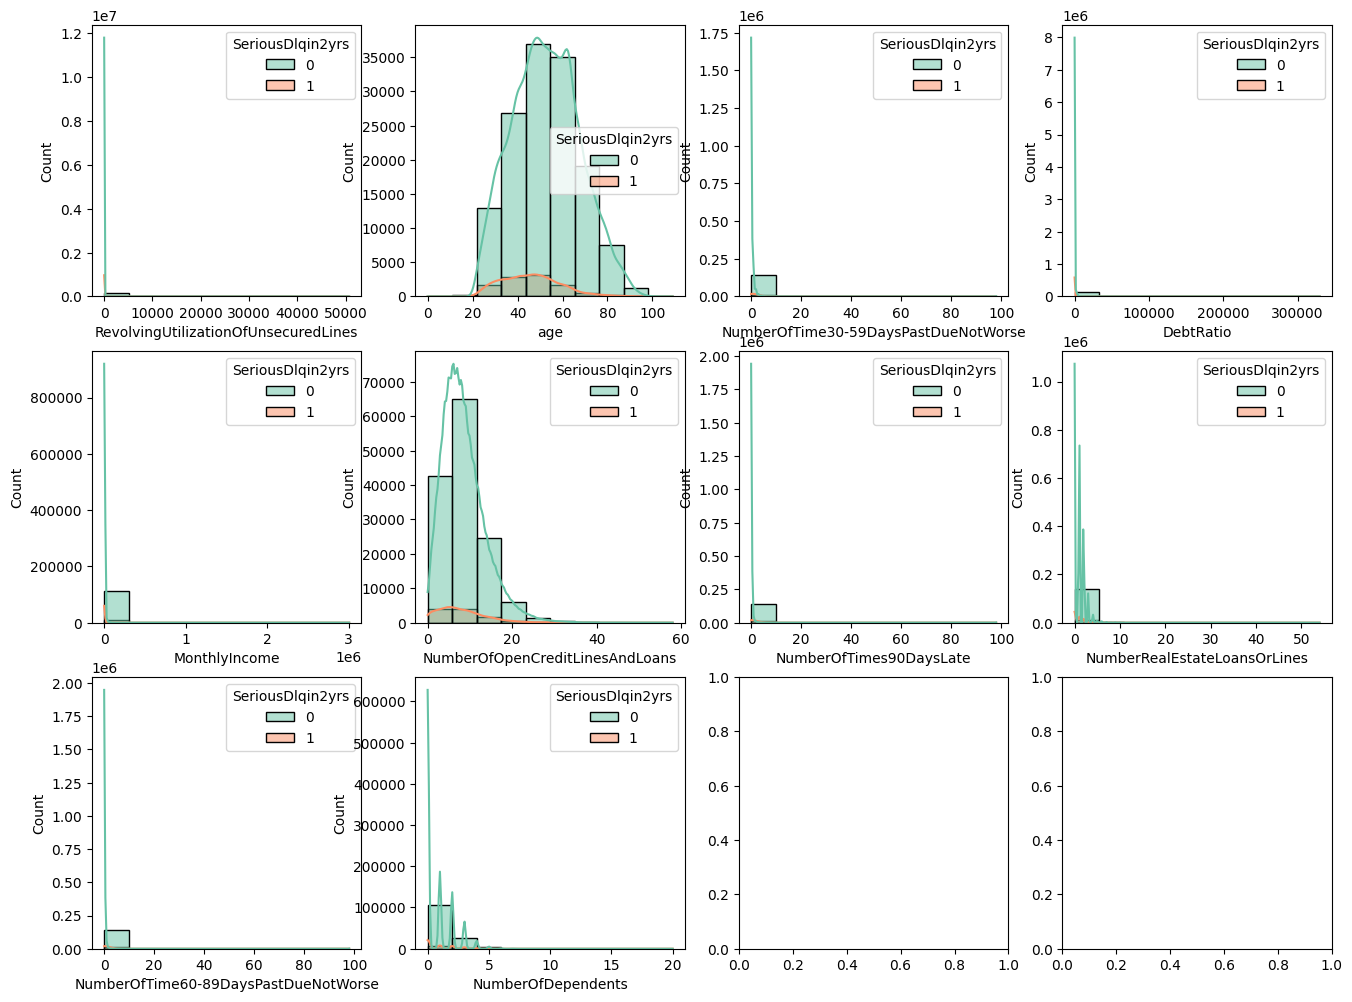

In [271]:
nc = 4
nr = int(len(features)//nc + np.ceil(len(features) * 1.0 /nc % 1))
fig, axs = plt.subplots(nr, nc, figsize=(4 * nc, 4 * nr))
for c, col in enumerate(features):
    sns.histplot(data=train, x=col, bins = 10, kde=True, color="skyblue", hue=col_target, ax=axs[c//nc, c%nc])
plt.show()

#### use K-L distance to check the importance of the data features

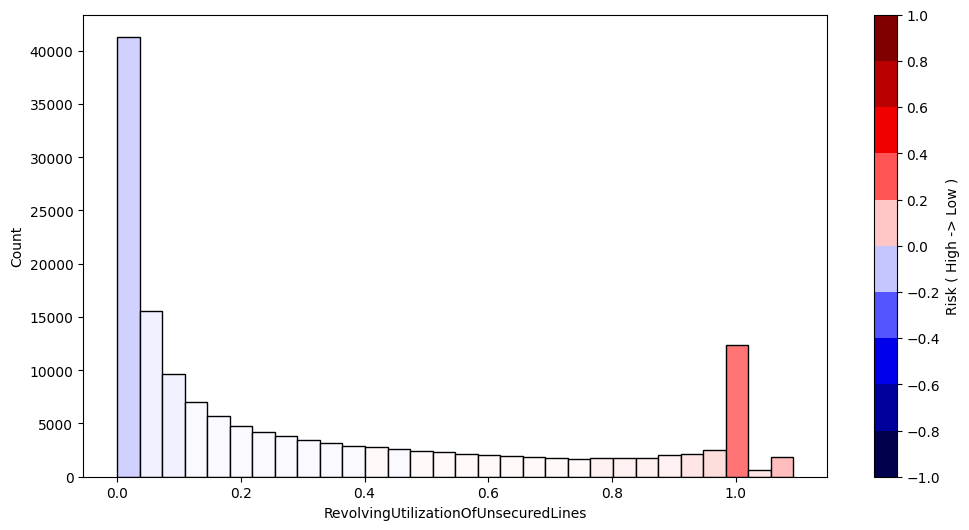

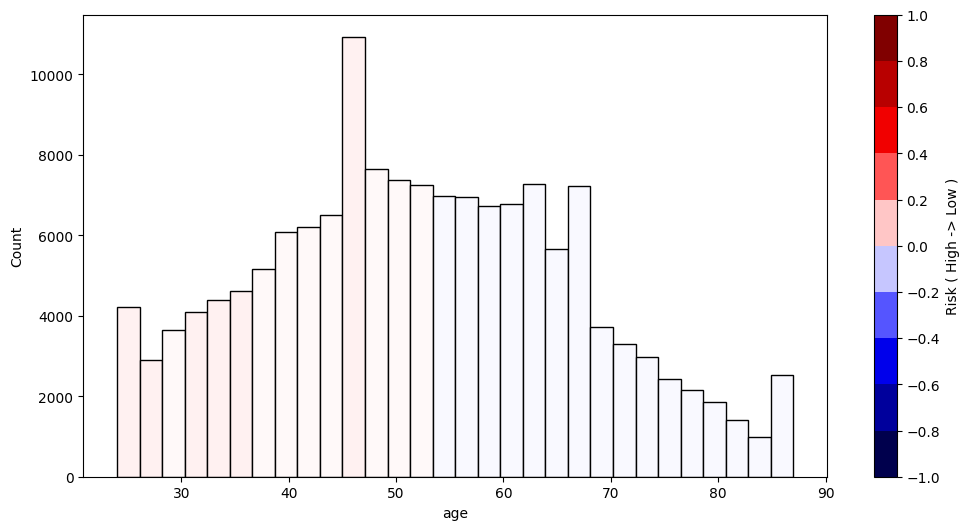

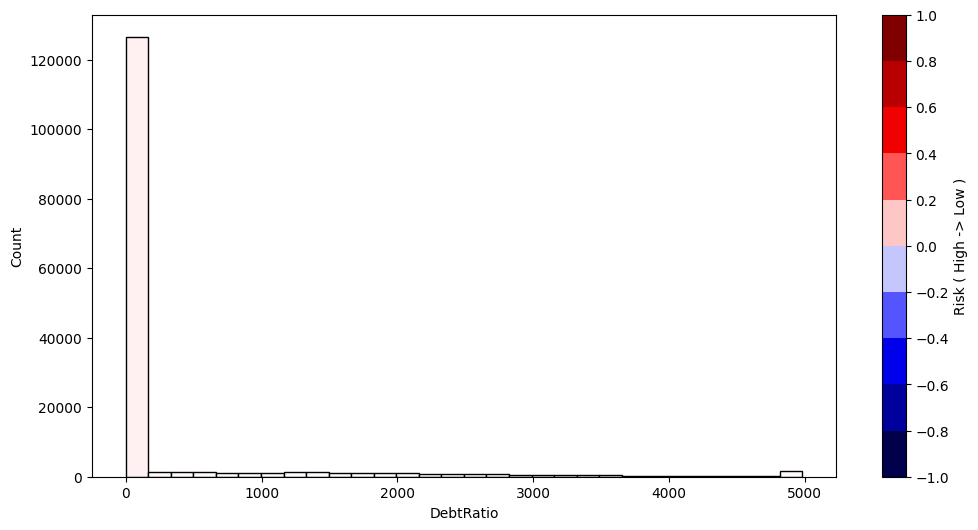

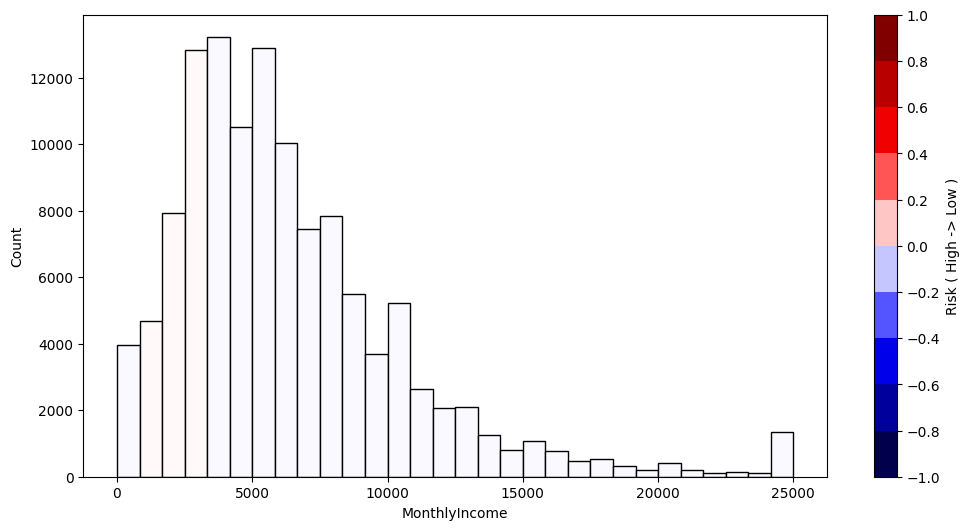

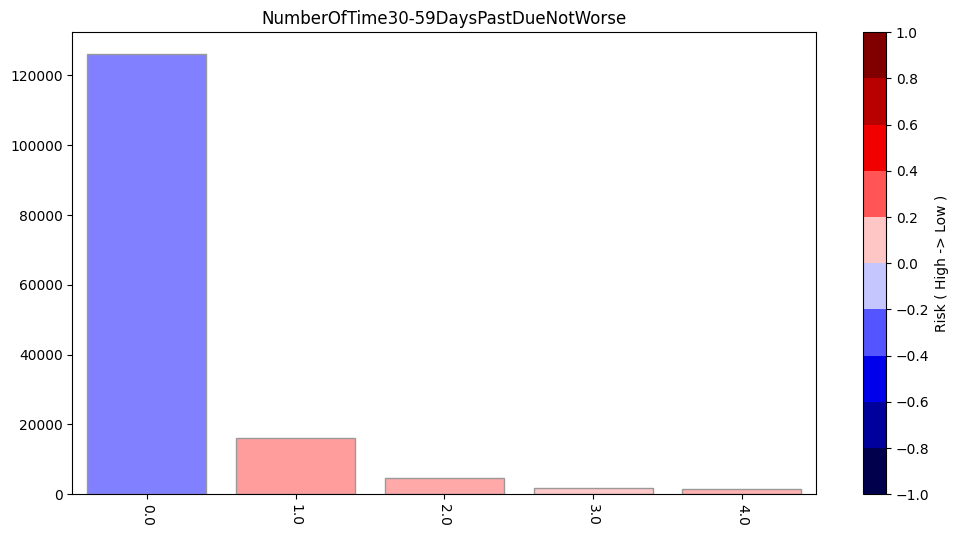

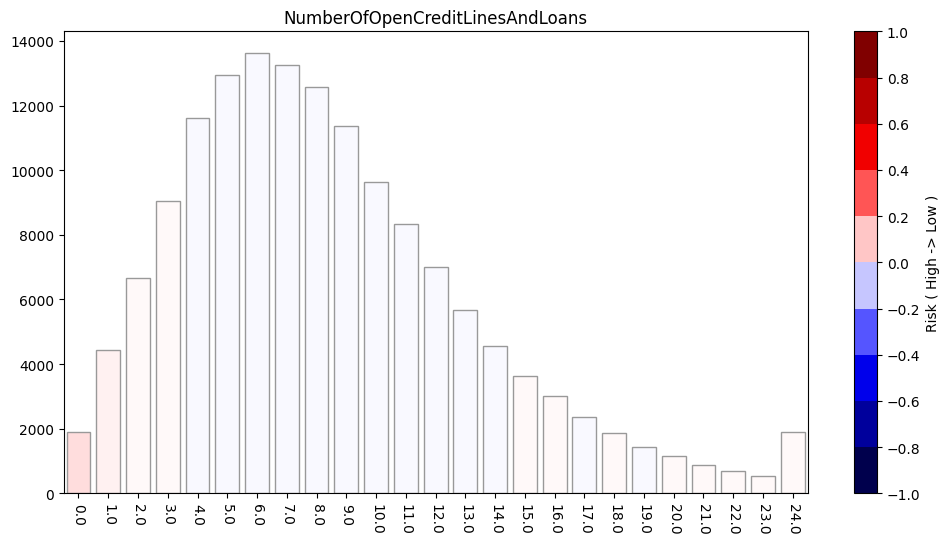

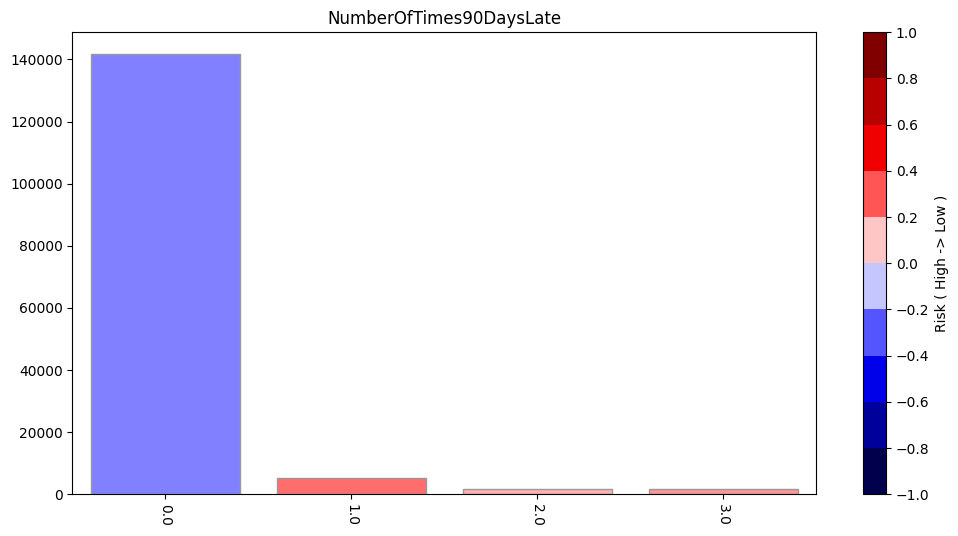

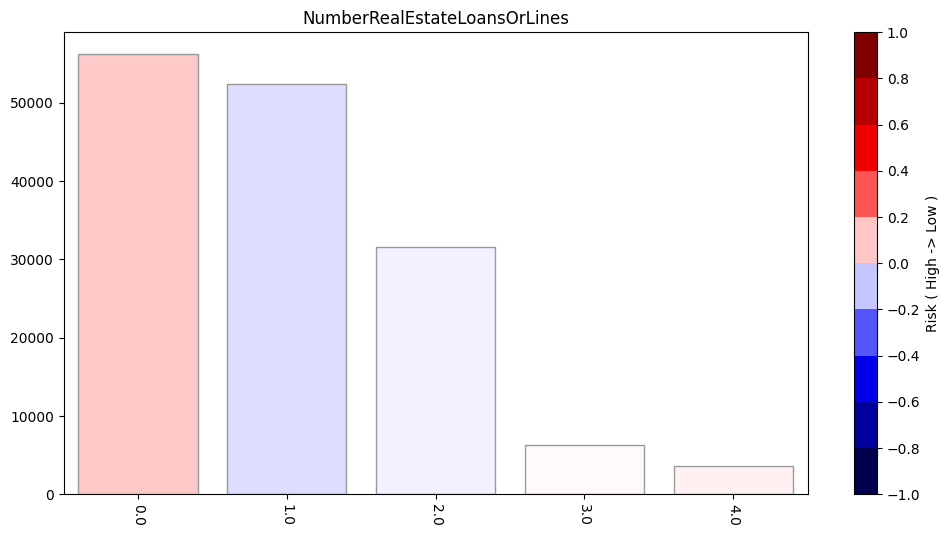

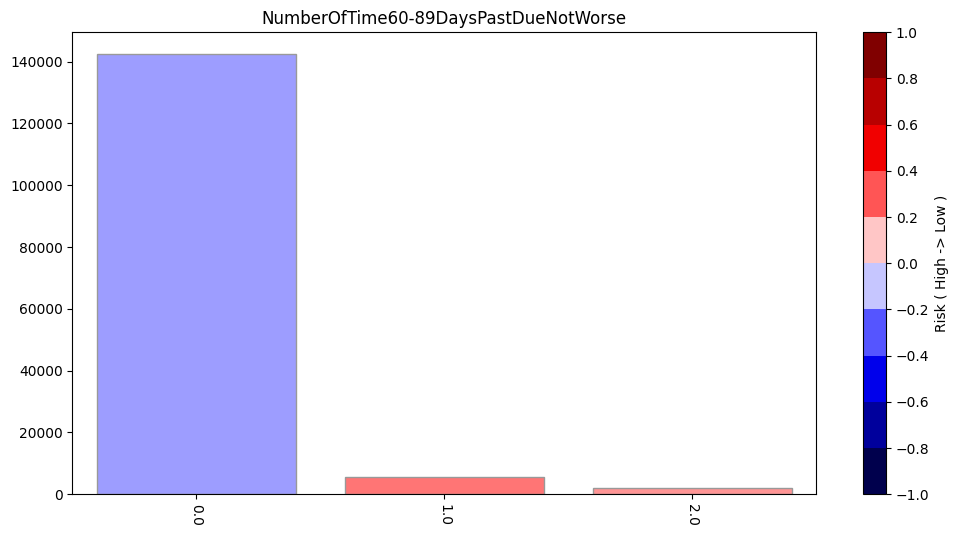

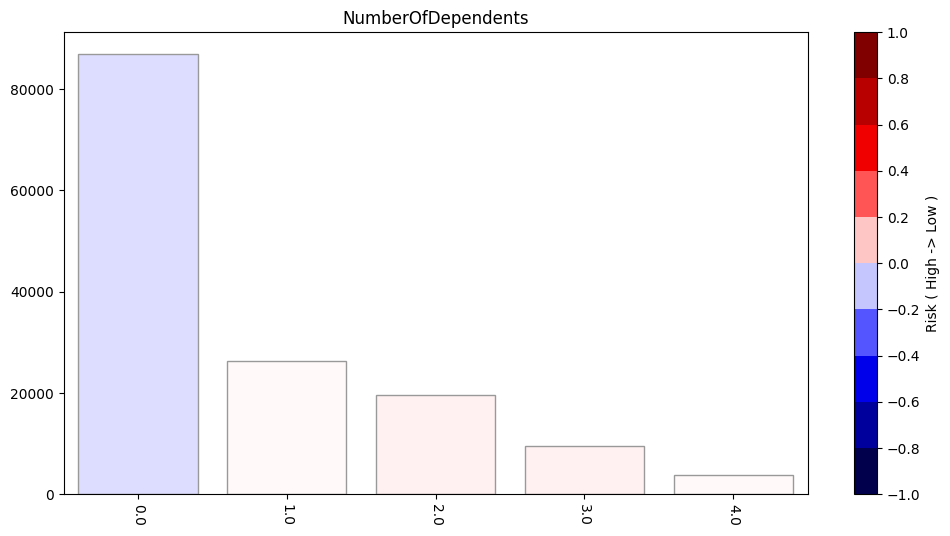

In [117]:
ls_feature_discrete, ls_feature_continuous, info_KL_feature, info_KL_feature_seg, info_split_feature = plot_KL_significance(train_no_outlier, features, col_target, thresh_n = 30, eps = 0.1)

### null value imputation

#### abnrmal value imputation

In [119]:
train.loc[train['age'] == 0,'age'] = np.nan

In [120]:
train["age"].min()

21.0

#### preprocess data with scaler

In [178]:
preprocess = Pipeline([
    ('scaler', RobustScaler())])
train_preprocess = preprocess.fit_transform(train[features])

#### data linearity

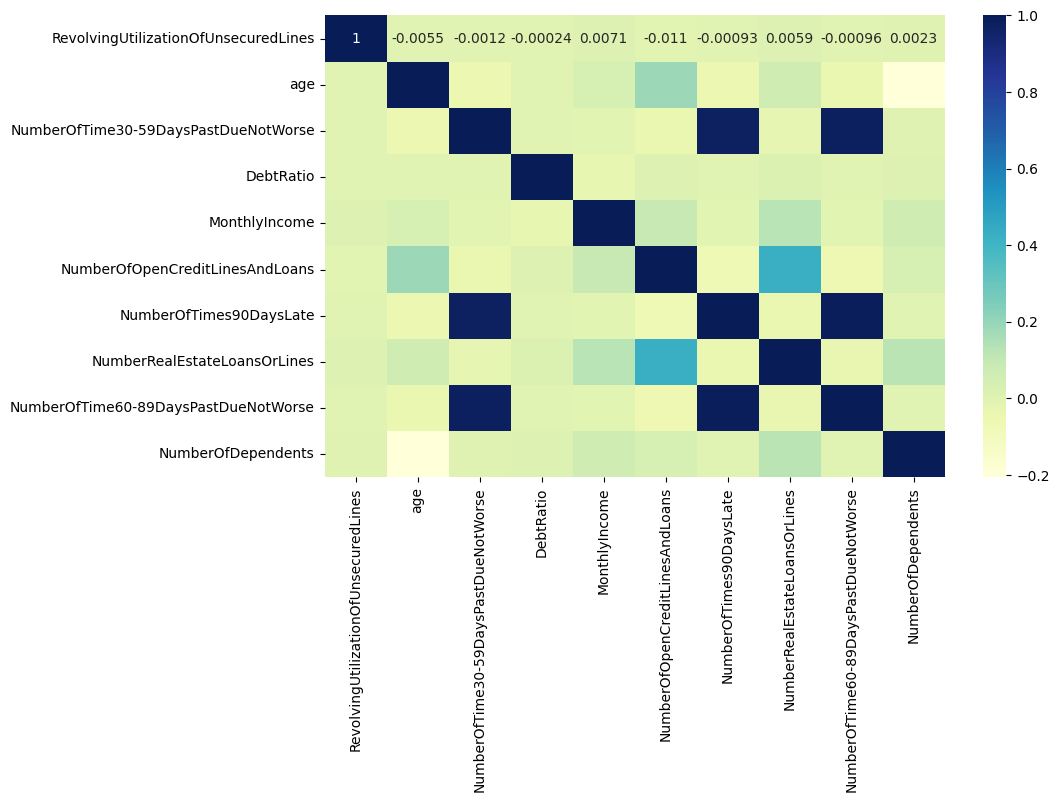

In [261]:
df_train_preprocess = pd.concat([train.iloc[:, :2], pd.DataFrame(train_preprocess, columns=features)], axis = 1)
df_train_preprocess.dropna(how='any', axis = 0, inplace = True)
plt.figure(figsize=(10, 6))
df_corr_train = df_train_preprocess[features].corr()
dataplot = sns.heatmap(df_corr_train, cmap="YlGnBu", annot=True)
plt.show()

In [262]:
df_corr_train

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
RevolvingUtilizationOfUnsecuredLines,1.000000,-0.005477,-0.001194,-0.000243,0.007124,-0.010880,-0.000931,0.005895,-0.000955,0.002347
age,-0.005477,1.000000,-0.049174,-0.001262,0.037718,0.187107,-0.047893,0.065137,-0.043505,-0.206379
NumberOfTime30-59DaysPastDueNotWorse,-0.001194,-0.049174,1.000000,-0.001981,-0.010217,-0.043867,0.975259,-0.024037,0.980131,0.003537
DebtRatio,-0.000243,-0.001262,-0.001981,1.000000,-0.028712,0.008685,-0.002703,0.019574,-0.001801,0.009804
MonthlyIncome,0.007124,0.037718,-0.010217,-0.028712,1.000000,0.091455,-0.012743,0.124960,-0.011116,0.062648
NumberOfOpenCreditLinesAndLoans,-0.010880,0.187107,-0.043867,0.008685,0.091455,1.000000,-0.072249,0.426542,-0.061506,0.038346
NumberOfTimes90DaysLate,-0.000931,-0.047893,0.975259,-0.002703,-0.012743,-0.072249,1.000000,-0.040573,0.989277,-0.003778
NumberRealEstateLoansOrLines,0.005895,0.065137,-0.024037,0.019574,0.124960,0.426542,-0.040573,1.000000,-0.034118,0.118991
NumberOfTime60-89DaysPastDueNotWorse,-0.000955,-0.043505,0.980131,-0.001801,-0.011116,-0.061506,0.989277,-0.034118,1.000000,-0.005092
NumberOfDependents,0.002347,-0.206379,0.003537,0.009804,0.062648,0.038346,-0.003778,0.118991,-0.005092,1.000000


### Customer Profile

- Customer # of train data is 150,000 while no gender info
>
- Customer average age 52 while min age is 24 (21 for test data)
- For NumberOfDependents, the median value is 0 while only 41% of the customers have GTE 1 dependents. Considering the avg age is 52, this is not very reasonable. A little suspicious about the data source, the data maybe input by the customers themselves.
- For MonthlyIncome, the median value is 4,400 while average is 5,154
- For DebtRatio, the median value is 36.6% (Assume the unit here is not percentage)
- For NumberOfOpenCreditLinesAndLoans, the median and avg value is 8 
- For RevolvingUtilizationOfUnsecuredLines, the median value is 15% which while avg is 30%. This means there are heavy CreditCard users
>
- For NumberOfTime30-59DaysPastDueNotWorse, there is 16% customers have GTE 1 times
- For NumberOfTime60-89DaysPastDueNotWorse, there is 5% customers have GTE 1 times
- For NumberOfTimes90DaysLate, there is 5.5% customers have GTE 1 times

#### train-validate data split (70% - 30%)

In [128]:
X_train, X_validate, y_train, y_validate = train_test_split(train[features], train[col_target], test_size = 0.3, random_state=18)

## 3. XGBoost Model

### Model Train

In [129]:
#X_train = train_preprocess_noscale.loc[:, features].to_numpy()
#y_train = train_preprocess_noscale.loc[:, ].to_numpy()

# Define the parameter grid for ExtraTreesClassifier
param_grid = {
        'min_child_weight': [3, 8, 15],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 10, 20]
        }

# Create an ExtraTreesClassifier instance
model = XGBClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
xgb = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict_proba(X_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


#### feature importance

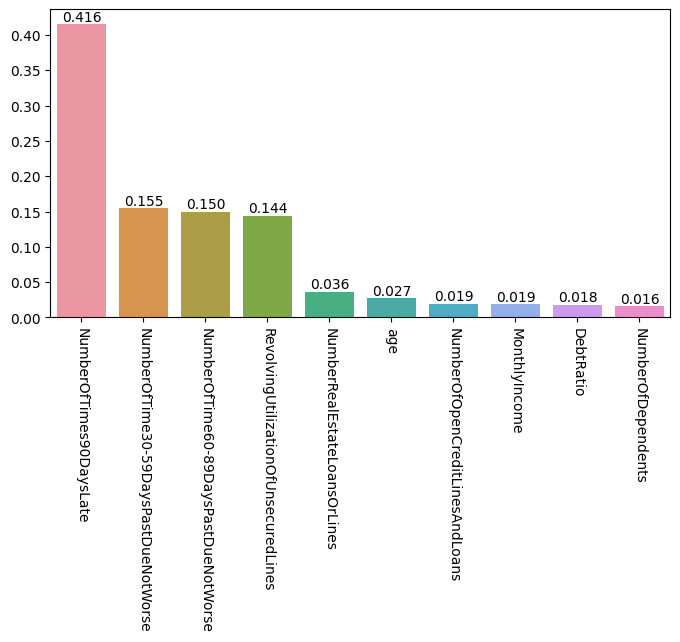

In [130]:
_, ax = plt.subplots(figsize=(8, 4))
importance_features = dict(zip(features, xgb.best_estimator_.feature_importances_))
importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse= True))
sns.barplot(x = list(importance_features.keys()), y = list(importance_features.values()))
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.xticks(rotation=-90)
plt.show()

We can see from the Xgboost feature importance that 
- 1. "NumberOfTimes90DaysLate" "NumberOfTime60-89DaysPastDueNotWorse" "NumberOfTime30-59DaysPastDueNotWorse" is very important for the classifier, this means once the customer was late due to the debt, the customer is very likely to be late again, especially 90 days late.
- 2. "RevolvingUtilizationOfUnsecuredLines" is also important to identify the high-risk customers
- 3. About the data confidence, we need to get the data source of all columns, especially MonthlyIncome and NumberOfDependents 

#### ROC curve

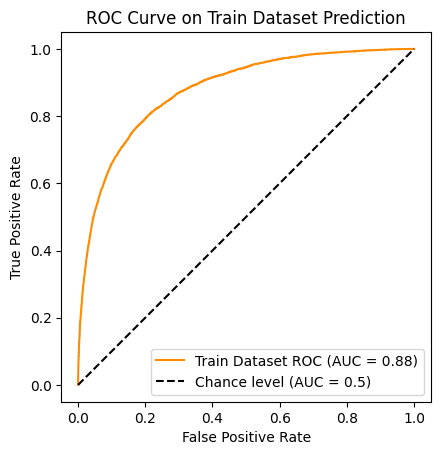

AUC of the model prediction on Train data is 0.8780


In [250]:
RocCurveDisplay.from_predictions(y_true=y_train,
    y_pred= y_pred_train[:, 1],
    name=f"Train Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_train, y_score = y_pred_train[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Train Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Train data is {auc:.4f}")

### Model Validation

#### ROC-AUC Curve

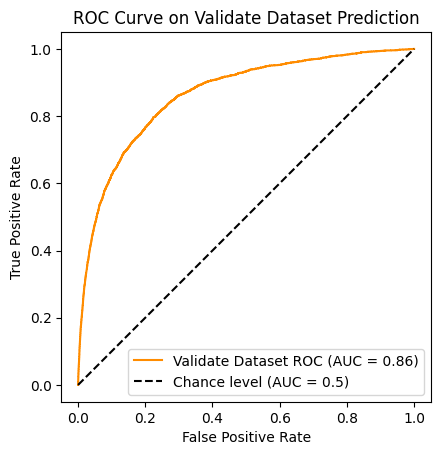

AUC of the model prediction on Validate data is 0.8631


In [132]:
y_pred_validate = xgb.predict_proba(X_validate)
RocCurveDisplay.from_predictions(y_true=y_validate,
    y_pred= y_pred_validate[:, 1],
    name=f"Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_validate, y_score = y_pred_validate[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Validate data is {auc:.4f}")

### Select Top high-Risk customers

In [251]:
#### get the optimal cutoff threshhold
info_cutoff = find_optimal_cutoff(target = y_validate, predict = y_pred_validate[:, 1])

#### make the data train 
data_validate  = pd.concat([X_validate, y_validate], axis = 1)
data_validate.loc[:, "xgb_pred"] = y_pred_validate[:, 1]
data_validate_cutoff = data_validate[data_validate["xgb_pred"] > 0.5]

#### get proportion of the data 
#proportion_top = data_validate_cutoff.shape[0] * 1.0 / data_validate.shape[0]
#print(f"proportion of the Top predict train data is {proportion_top * 100.0:.2f}%")

<b>Findings:
- proportion of the Top predict train data is 25.35%
- The current precision 24.62% is not high enough to filter out the high-risk potential bad customers
- If we select the best cutoff point, we can cover ~80% of all bad customers while 20% of good customers will be wrongly labeled.

In [286]:
### data_validate_cutoff.shape[0] * 1.0 / data_validate.shape[0]

In [287]:
data_validate_cutoff[col_target].sum()* 1.0 / data_validate_cutoff.shape[0]

0.5569285083848191

Fitting 5 folds for each of 32 candidates, totalling 160 fits


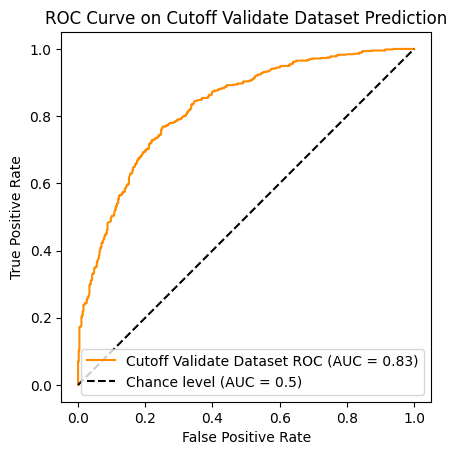

AUC of the model prediction on Cutoff Validate data is 0.8271


In [252]:
X_validate_cutoff = data_validate_cutoff.loc[:, features].to_numpy()
y_validate_cutoff = data_validate_cutoff.loc[:, col_target].to_numpy()

# Create an ExtraTreesClassifier instance
model_validate_cutoff = XGBClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
xgb_validate_cutoff = RandomizedSearchCV(
    model_validate_cutoff,
    param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
xgb_validate_cutoff.fit(X_validate_cutoff, y_validate_cutoff)
y_pred_validate_cutoff = xgb_validate_cutoff.predict_proba(X_validate_cutoff)

# ROC curve
RocCurveDisplay.from_predictions(y_true=y_validate_cutoff,
    y_pred= y_pred_validate_cutoff[:, 1],
    name=f"Cutoff Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = y_validate_cutoff, y_score = y_pred_validate_cutoff[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Cutoff Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Cutoff Validate data is {auc:.4f}")

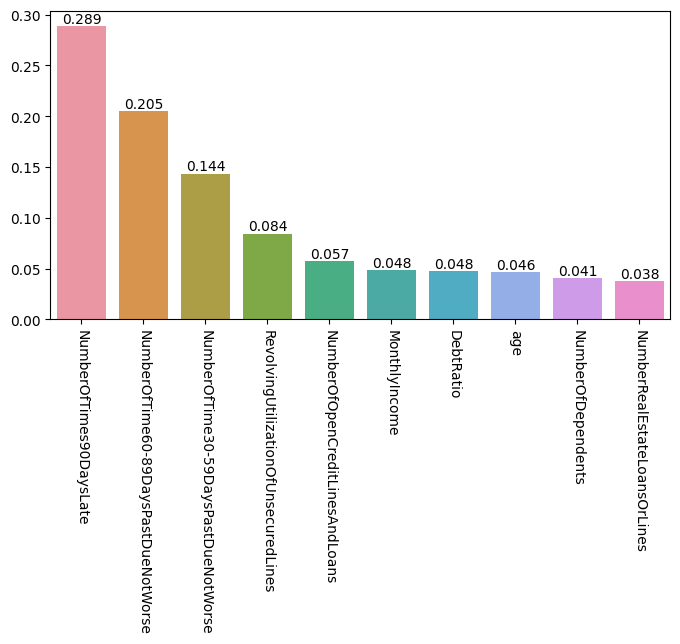

In [138]:
_, ax = plt.subplots(figsize=(8, 4))
importance_features = dict(zip(features, xgb_validate_cutoff.best_estimator_.feature_importances_))
importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse= True))
sns.barplot(x = list(importance_features.keys()), y = list(importance_features.values()))
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.xticks(rotation=-90)
plt.show()

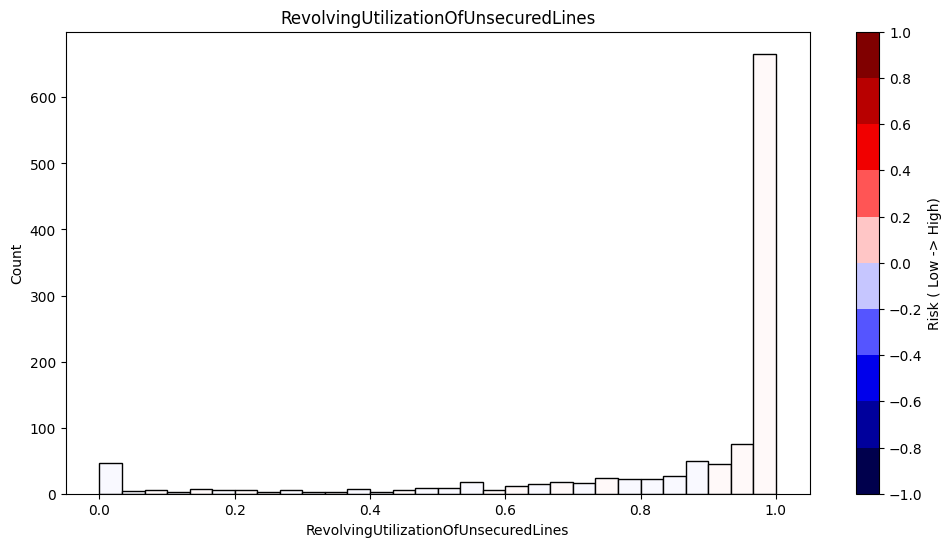

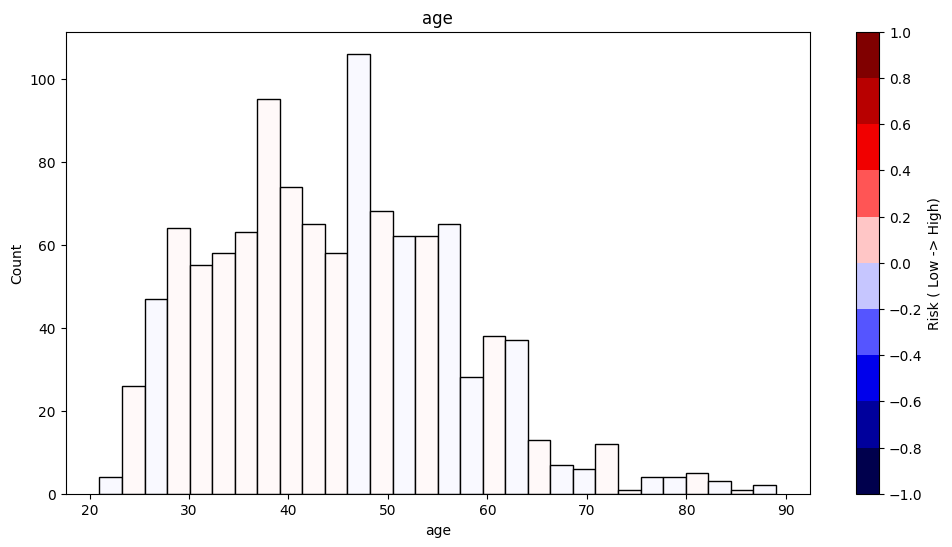

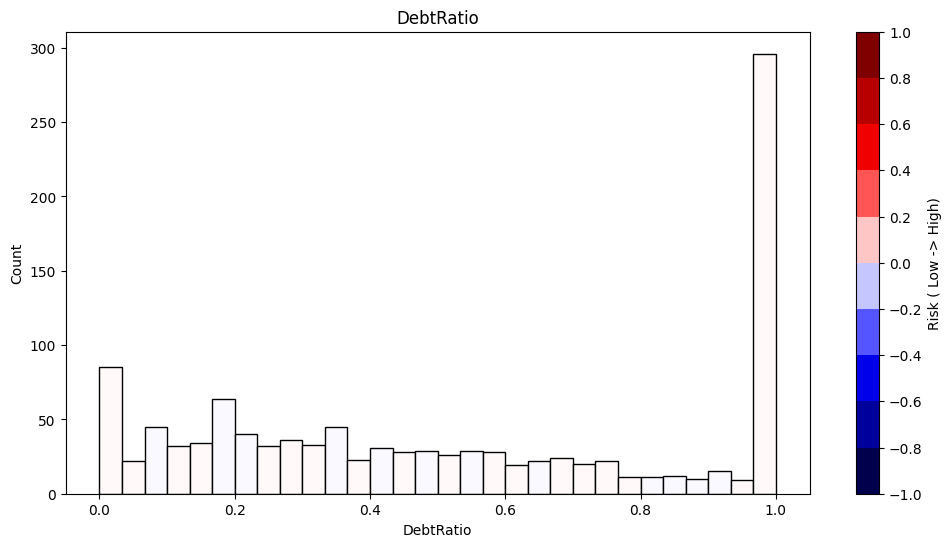

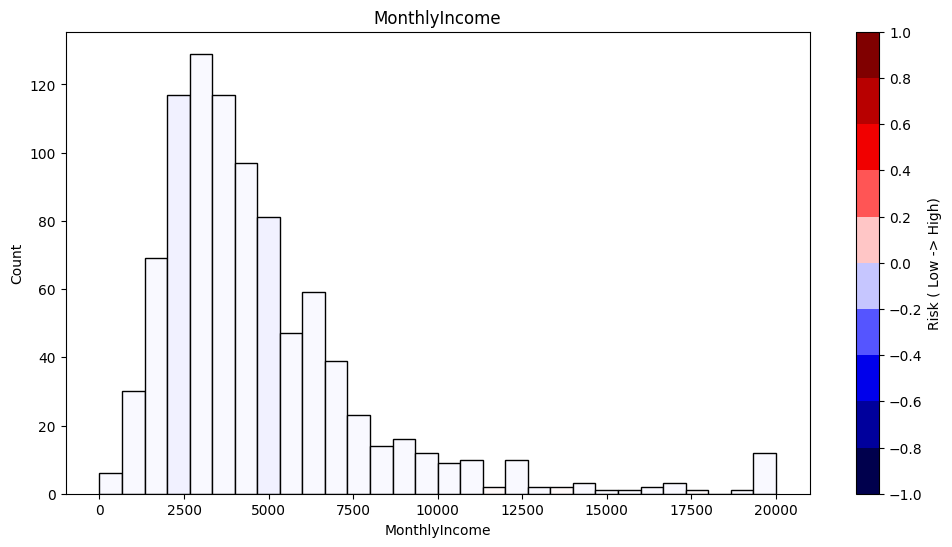

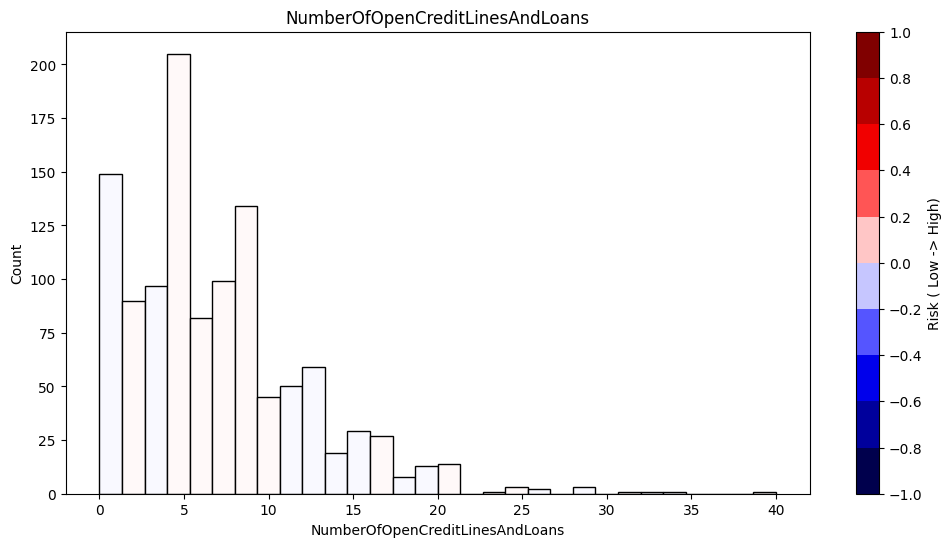

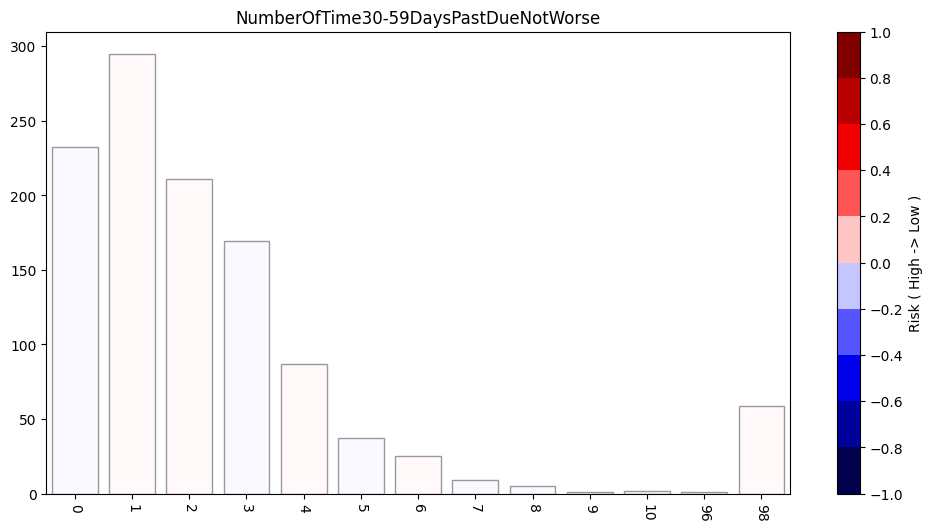

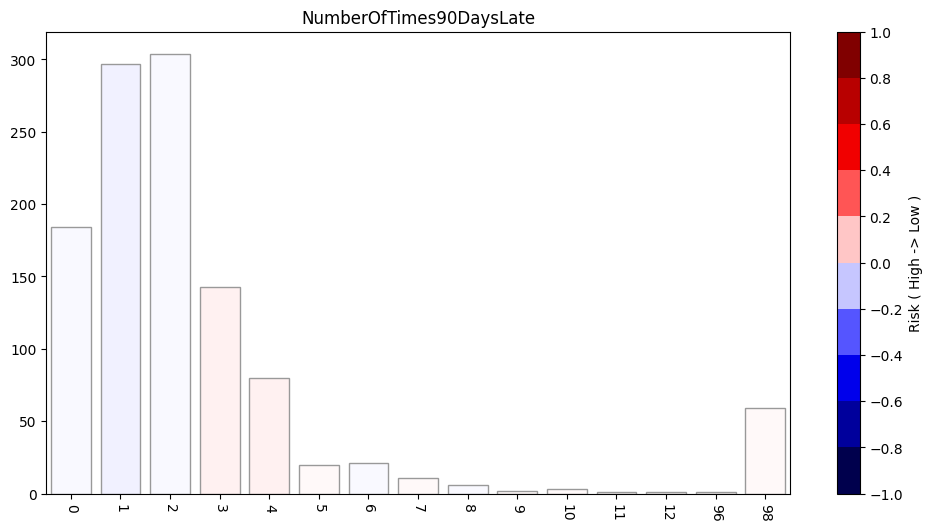

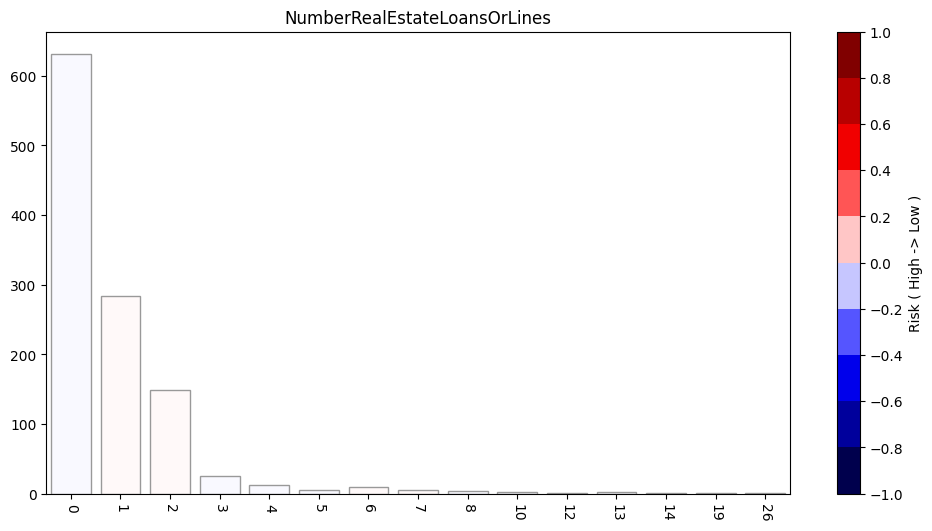

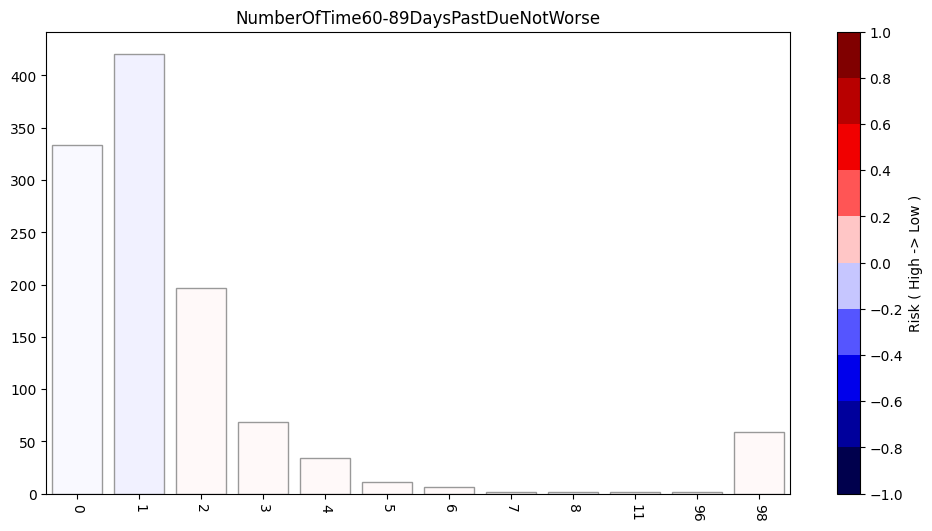

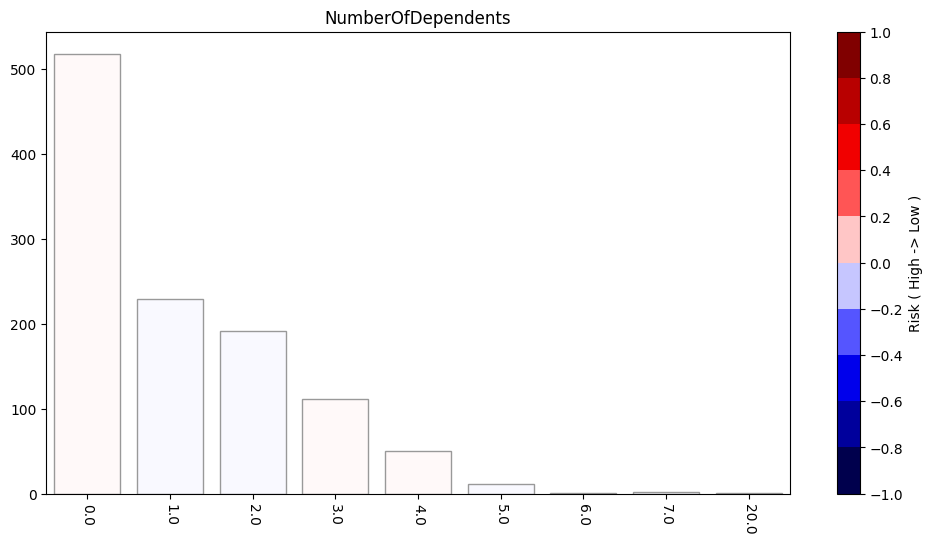

In [253]:
data_validate_cutoff_features = data_validate_cutoff.reset_index().rename(columns={"index": "id"})
data_validate_cutoff_features.loc[:, "RevolvingUtilizationOfUnsecuredLines"] = data_validate_cutoff_features["RevolvingUtilizationOfUnsecuredLines"].apply(lambda x : 1 if x > 1 else x)
data_validate_cutoff_features.loc[:, "DebtRatio"] = data_validate_cutoff_features["DebtRatio"].apply(lambda x : 1 if x > 1 else x)
data_validate_cutoff_features.loc[:, "MonthlyIncome"] = data_validate_cutoff_features["MonthlyIncome"].apply(lambda x : 20000 if x > 20000 else x)
ls_feature_discrete, ls_feature_continuous, info_KL_feature, info_KL_feature_seg, info_split_feature = plot_KL_significance(data_validate_cutoff_features, features, col_target, thresh_n = 30, eps = 0.1)

#### Decision Tree Model

In [257]:
reg_cart = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split= 50)
reg_cart.fit(X_validate_cutoff, y_validate_cutoff)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=50)

In [258]:
text_representation = tree.export_text(reg_cart,feature_names=features)
print(text_representation)

|--- NumberOfTimes90DaysLate <= 2.50
|   |--- value: [0.51]
|--- NumberOfTimes90DaysLate >  2.50
|   |--- age <= 47.50
|   |   |--- value: [0.70]
|   |--- age >  47.50
|   |   |--- MonthlyIncome <= 6472.00
|   |   |   |--- value: [0.65]
|   |   |--- MonthlyIncome >  6472.00
|   |   |   |--- value: [0.45]



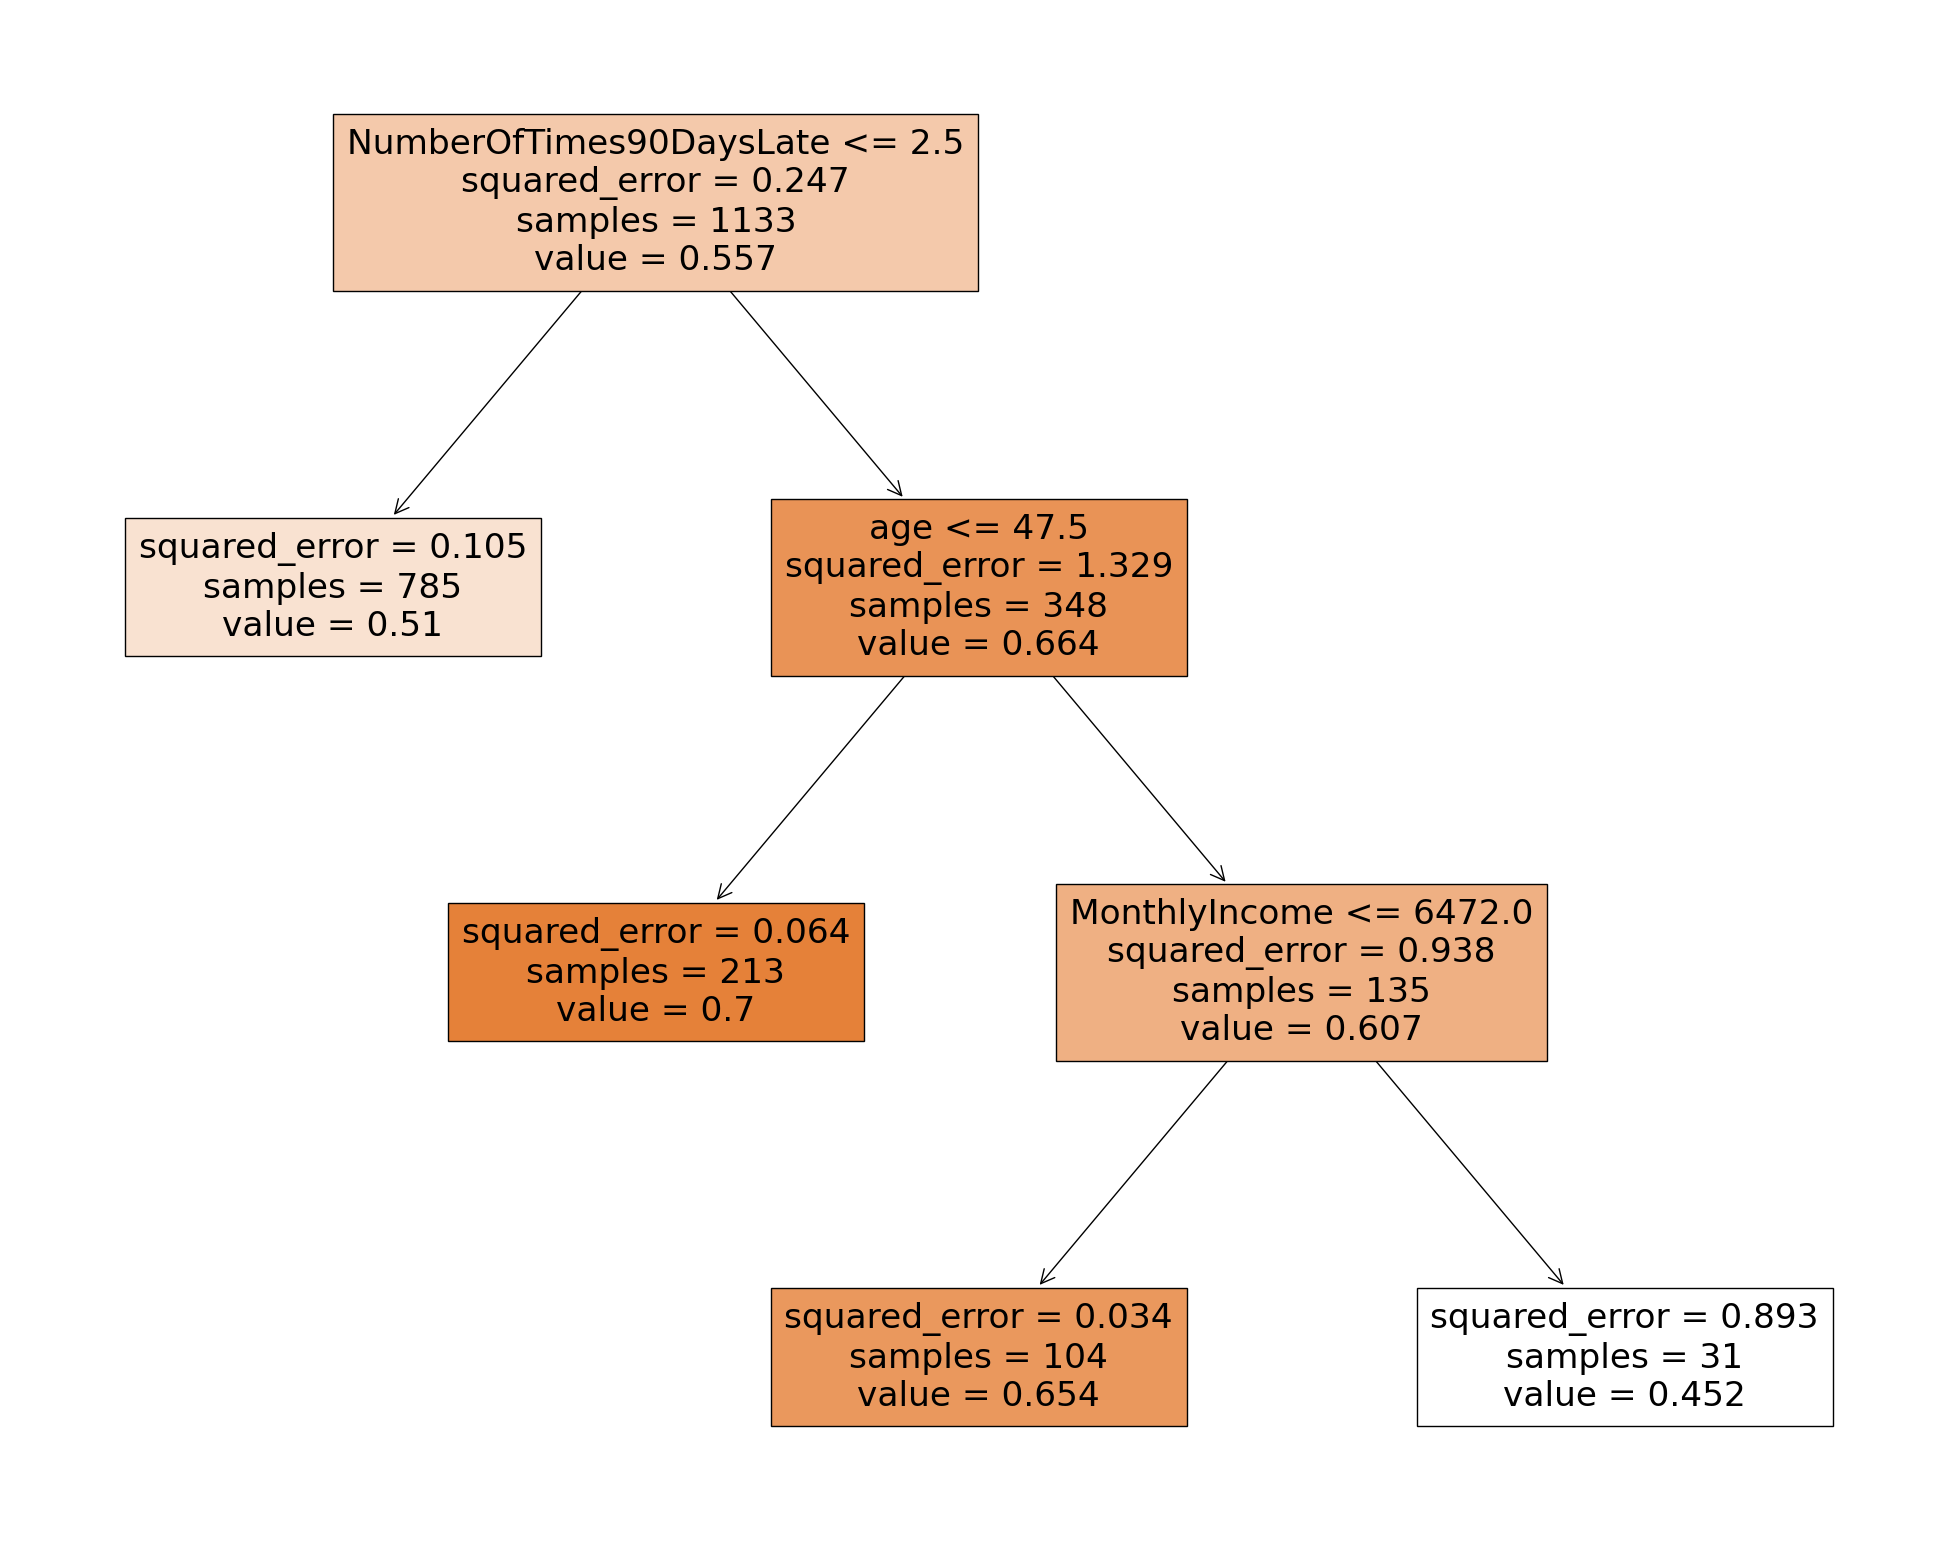

In [259]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(reg_cart, feature_names=features, filled=True, class_names = ["Low", "High"])

### 4. Logistic Regression Models

#### 4.1 Train-validate split (70 - 30)

In [190]:
lrX_train, lrX_validate, lry_train, lry_validate = train_test_split(df_train_preprocess[features].to_numpy(), df_train_preprocess[col_target].to_numpy(), test_size = 0.3, random_state=18)

##### 4.2 PCA preprocess to remove non-linearity

In [229]:
pca = PCA(n_components=len(features))
lrX_train_pca = pca.fit_transform(lrX_train)
lrX_validate_pca = pca.transform(lrX_validate)

#### 4.3 Model train & Predict

In [230]:
lrm = LogisticRegression(random_state=0, max_iter= 1000).fit(lrX_train_pca, lry_train)
lry_pred_train = lrm.predict_proba(lrX_train_pca)
lry_pred_validate = lrm.predict_proba(lrX_validate_pca)

#### 4.4 Train Data Performance

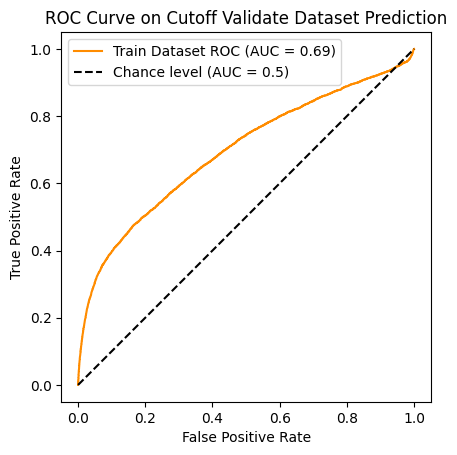

AUC of the model prediction on Cutoff Validate data is 0.6941


In [231]:
# ROC curve
RocCurveDisplay.from_predictions(y_true=lry_train,
    y_pred= lry_pred_train[:, 1],
    name=f"Train Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = lry_train, y_score = lry_pred_train[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Cutoff Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Cutoff Validate data is {auc:.4f}")

#### 4.5 Validate Data Performance

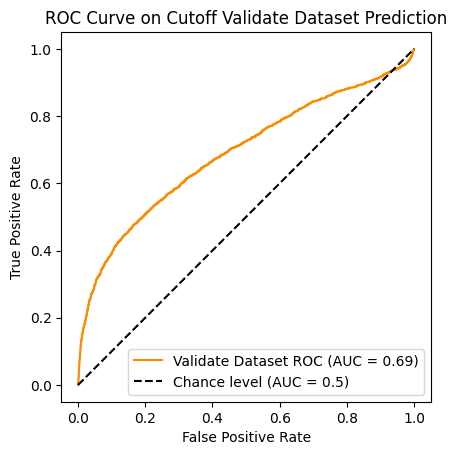

AUC of the model prediction on Cutoff Validate data is 0.6883


In [232]:
# ROC curve
RocCurveDisplay.from_predictions(y_true=lry_validate,
    y_pred= lry_pred_validate[:, 1],
    name=f"Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = lry_validate, y_score = lry_pred_validate[:, 1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Cutoff Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Cutoff Validate data is {auc:.4f}")

### 5. CNN Model

In [263]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
 
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class CNNNet(nn.Module):
    def __init__(self, n_feature,  dropout = 0.1):
        super(CNNNet, self).__init__()
        # Layer 1
        self.dropout = nn.Dropout(dropout)
        self.layers = clones(nn.Conv1d(1, 10, 10, padding = 0), 3)
        self.norm = LayerNorm(n_feature)
        self.f1 = nn.Linear(10, 2)
        
    def forward(self, x):
        for layer in self.layers:
            # x = x + self.norm(self.dropout(layer(x).transpose(-2, -1)))
            x = self.norm(self.dropout(layer(x).transpose(-2, -1)))
        out1 = x.contiguous().view(x.size(0), -1)
        out2 = self.f1(out1).softmax(dim=-1)
        # return x + self.dropout(sublayer(self.norm(x)))
        return out2

#### 4.1 Train-Validate data split for preprocessed train data

In [264]:
tX_train, tX_validate, ty_train, ty_validate = train_test_split(df_train_preprocess[features].to_numpy(), df_train_preprocess.loc[:,col_target].to_numpy(), test_size = 0.3, random_state=18)

# turn into Tensors
tX_train = torch.Tensor(tX_train).unsqueeze(1)
ty_train = torch.Tensor(ty_train)
tX_validate = torch.Tensor(tX_validate).unsqueeze(1)

#### 4.2 model build

In [265]:
criterion = nn.BCELoss()
learning_rt = 0.1
cnn  = CNNNet(n_feature = 10)
optimizer = optim.RMSprop(cnn.parameters(), lr=learning_rt)

#### 4.3 model train

In [267]:
batch_size = 1000
epoches = 100
cnn.train()
for epoch in range(epoches):
    ls_loss = []
    for n_batch in range(tX_train.size(0)//batch_size):
        batch_tX_train = tX_train[n_batch:n_batch+batch_size, :, :].clone().detach()
        batch_ty_train = ty_train[n_batch:n_batch+batch_size].clone().detach()
        batch_pred  = cnn(batch_tX_train)
        loss = criterion(batch_pred[:, 1], batch_ty_train)
        ls_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # print(f"epoch - {epoch} : {np.mean(ls_loss)}")

#### 4.4 model train performance

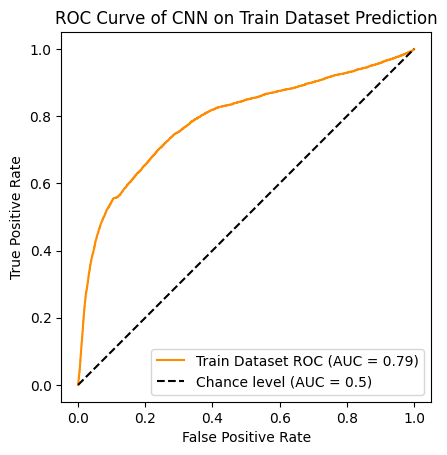

AUC of the model prediction on Train data is 0.7888


In [269]:
cnn.eval()
train_pred  = cnn(tX_train)

RocCurveDisplay.from_predictions(y_true=ty_train,
    y_pred= train_pred[:, 1].detach().numpy(),
    name=f"Train Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = ty_train, y_score = train_pred[:, 1].detach().numpy(), pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of CNN on Train Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Train data is {auc:.4f}")

#### 4.5 model validate

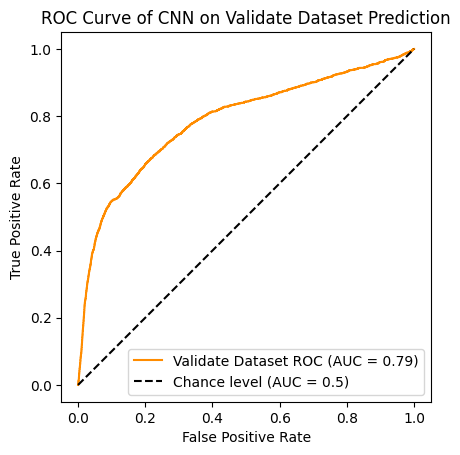

AUC of the model prediction on Validate data is 0.7866


In [270]:
cnn.eval()
validate_pred  = cnn(tX_validate)

RocCurveDisplay.from_predictions(y_true=ty_validate,
    y_pred= validate_pred[:, 1].detach().numpy(),
    name=f"Validate Dataset ROC",
    color="darkorange",
    plot_chance_level=True,
)
fpr, tpr, thresholds = metrics.roc_curve(y_true = ty_validate, y_score = validate_pred[:, 1].detach().numpy(), pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of CNN on Validate Dataset Prediction")
plt.legend()
plt.show()
print(f"AUC of the model prediction on Validate data is {auc:.4f}")